In [101]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from Data_Core.fft_analysis import *
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from transformer_final import *
from skimage import filters

# a. Auxiliary Functions

In [2]:
find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

def Raman_data_loader(filename):

    with h5py.File( filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties


def read_data_map(file):

    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])

    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y

def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

# 1. Import Raman Dataset

In [3]:
filename = "D:/Data/Data_Raman/Rocks/2023913_1110.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

## 1.1 Baseline Removal

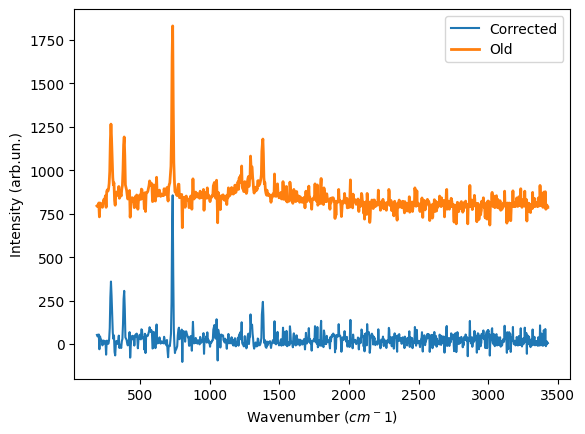

In [4]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

ix,iy = 0, 0
##optimize parameters
lam = 1e2
p=1e-1
baseline = baseline_als_optimized(spectrum_raman[ix,iy,:],lam=lam,p=p,niter=10)
fig,ax = subplots()
plot(wavelengths_raman, spectrum_raman[ix,iy,:] - baseline,label='Corrected')
plot(wavelengths_raman, spectrum_raman[ix,iy,:], lw=2,label='Old')
ax.set_xlabel(r'Wavenumber $(cm^-1)$')
ax.set_ylabel(r'Intensity (arb.un.)')
ax.legend()

In [5]:
pro_data = 1*spectrum_raman
for i in tqdm(range(0,pro_data.shape[0])):
    for j in range(0,pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i,j, :]
        pro_data[i,j,:] = spec - baseline_als_optimized(spec,lam=lam,p=p,niter=10)

100%|██████████| 250/250 [07:19<00:00,  1.76s/it]


In [6]:
pro_data[:,:,:31] = 0

## 1.2 Visualization

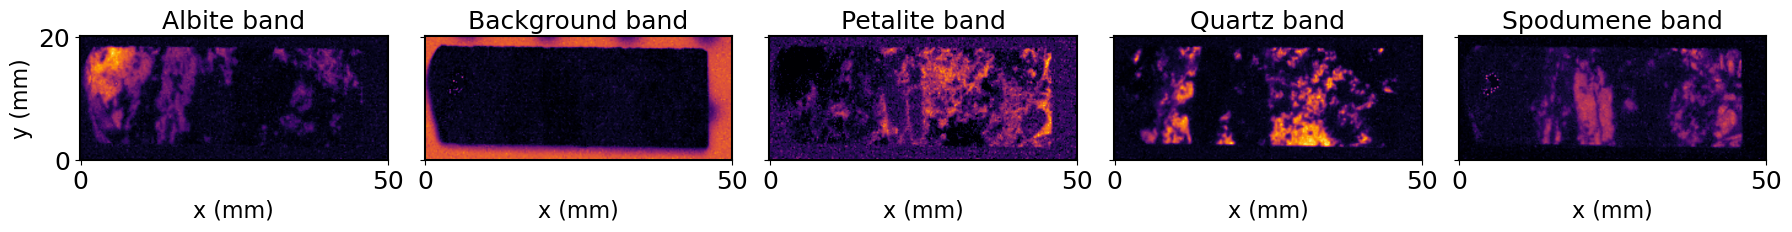

In [299]:
fig, ax = subplots(1, 5, figsize = (18, 15))

minerals = {
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())

for i, mineral in enumerate(mineral_list):
    axs = ax[i]
    setp(axs.spines.values(), linewidth = 1.5, color = 'k')
    axs.imshow(pro_data[:, :, find_index(wavelengths_raman, minerals[mineral][0])].T, cmap = 'inferno', interpolation = 'gaussian', vmin = -50)
    axs.set_title(f'{mineral} band', fontsize = 18)
    axs.set_yticks([0, 100])
    if i == 0:
        axs.set_yticklabels([20, 0], fontsize = 18)
    else:
        axs.set_yticklabels([], fontsize = 18)
    axs.set_xticks([0, 250])
    axs.set_xticklabels([0, 50], fontsize = 18)
    if i == 0:
        axs.set_ylabel('y (mm)', fontsize = 16)
    axs.set_xlabel('x (mm)', fontsize = 16)

fig.tight_layout(pad=1)
# savefig(r'Images/raman_bands.jpg', dpi = 300)

## 1.3 Comparision with reference spectrum

Albite
Background
Background not found
Petalite
Quartz
Spodumene


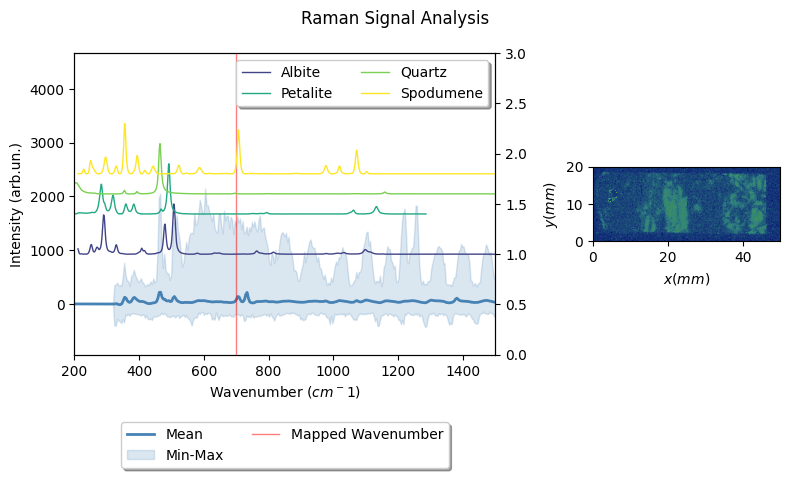

In [7]:
mean_signal = np.mean(pro_data, axis=(0,1))
min_signal = np.min(pro_data, axis=(0,1))
max_signal = np.max(pro_data, axis=(0,1))

# %matplotlib widget

fig, ax = subplots(1,2,figsize=[8,5],gridspec_kw={'width_ratios':[0.9,0.4]})
fig.suptitle('Raman Signal Analysis')
ax[0].plot(wavelengths_raman, mean_signal, lw = 2, ls = '-', color = 'steelblue', label = 'Mean')
ax[0].fill_between(wavelengths_raman, min_signal, max_signal, color = 'steelblue', alpha = 0.2, label = 'Min-Max')
wn = 120
line = ax[0].axvline(wavelengths_raman[wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
ax[0].set_xlabel(r'Wavenumber $(cm^-1)$')
ax[0].set_ylabel(r'Intensity (arb.un.)')
ax[0].legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

ax0 = ax[0].twinx()

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        ax0.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
ax0.set_ylim(0,1+0.2*(i+1)+1)
ax0.set_xlim(200,1500)
    
ax0.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
sca(ax[0])



ax[1].imshow(pro_data[:,:,wn].T, cmap = cm.gist_earth, extent = [0,exp_properties['step_size']*exp_properties['n_points'][0],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][1]])
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(pro_data[:,:,wn].T,cmap=cm.inferno,
                      extent=[0,exp_properties['step_size']*exp_properties['n_points'][0],
                            0,exp_properties['step_size']*exp_properties['n_points'][1]],
                     interpolation = 'gaussian')
    line.set_xdata(wavelengths_raman[wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman, ix)
    if event.inaxes == ax[0] or event.inaxes == ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)


fig.tight_layout()

## 1.4 Data processing

### 1.4.1 Guassian Filter and normalize to spectra sum

In [8]:
from scipy.ndimage import gaussian_filter1d

norm_data = pro_data.reshape(pro_data.shape[0]*pro_data.shape[1], -1)
norm_data = np.array([gaussian_filter1d(norm_data[i, :]/np.sum(norm_data[i, :]), sigma = 1) for i in range(0, norm_data.shape[0])])
norm_data = norm_data.reshape(pro_data.shape)

### 1.4.2 Aggregate All Features for Clustering

In [9]:
features = []
radius = 2

for i, mineral in enumerate(mineral_list):
    wn = find_index(wavelengths_raman, minerals[mineral][0])
    new_array = norm_data[:, :, wn-radius : wn+radius].mean(axis = -1)
    #features.append(new_array)#/np.max(new_array))
    features.append( ( new_array - np.min(new_array) ) / (np.max(new_array) - np.min(new_array)))
    
features = np.transpose(np.array(features), axes = (1, 2, 0))
features = features.reshape([features.shape[0]*features.shape[1],features.shape[2]])

initial_mineral_list = mineral_list

## 1.5 Clustering

### 1.5.1 Parameter Tuning

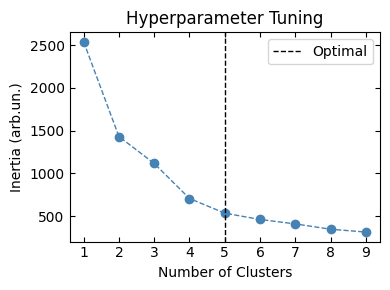

In [10]:
ncs = [i for i in range(1,10)]
inertias = []
for n_clusters in ncs:
    model = sklearn.cluster.KMeans(n_clusters = n_clusters, random_state=0)
    model.fit(features)
    inertias.append(model.inertia_)

fig,ax = plt.subplots(figsize=[4,3])
ax.set_title('Hyperparameter Tuning')
ax.plot(ncs, inertias, marker = 'o', color='steelblue', lw=1,ls='--')
ax.axvline(5,color='k',lw=1,ls='--',label='Optimal')
ax.legend()
ax.set_xlabel('Number of Clusters')
ax.set_xticks(ncs)
ax.set_ylabel('Inertia (arb.un.)')
ax.tick_params(axis='both',direction="in",top=True,right=True)
fig.tight_layout()

### 1.5.2 Cluster Initialization 

In [11]:
n_clusters = 5

# Cluster centers already initialized to match those of the predicted features
#ALBITE; BACKGROUND; PETALITE; QUARTZ; SPODUMENE
clusters_init = [ [1,0,0,0,0], 
                  [0,1,0,0,0],
                  [0,0,1,0,0],
                  [0,0,0,1,0],
                  [0,0,0,0,1] ]

model = sklearn.cluster.KMeans(n_clusters = n_clusters, init = np.array(clusters_init), random_state = 100)
model.fit(features)
predictions = model.predict(features)

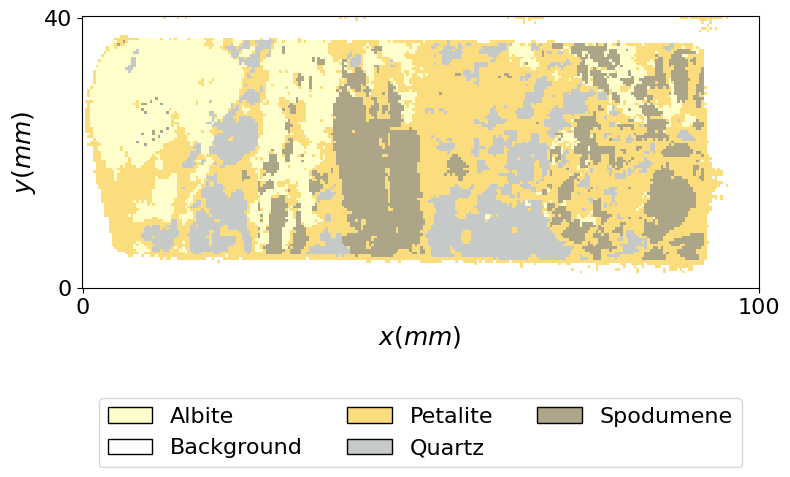

In [12]:
fig, ax = subplots(1,1,figsize = (8, 6))

# colors = ['xkcd:dark coral','xkcd:white','xkcd:sandy','xkcd:almost black','xkcd:topaz']
colors = ['xkcd:ecru', 'xkcd:white',  'xkcd:wheat' , 'xkcd:silver','xkcd:stone']
cmp1 = ListedColormap(colors[:n_clusters])


imshow(predictions.reshape(norm_data.shape[0], norm_data.shape[1]).T, interpolation = 'nearest', cmap = cmp1)

hls = []
for color,cluster in zip(colors, mineral_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

# ax.set_title('Unsupervised Classification Results')
ax.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (0.5, -0.7), ncol = 3, fontsize = 16)
ax.set_xlabel(r'$x(mm)$', fontsize = 18)
ax.set_ylabel(r'$y(mm)$', fontsize = 18)
ax.set_xticks([0,250])
ax.set_xticklabels([0, 100], fontsize = 16)
ax.set_yticks([0, 100])
ax.set_yticklabels([40, 0], fontsize = 16)

fig.tight_layout()
# savefig('Classification_map.png',dpi = 300)

## 1.6 Reference Spectra to Captured Spectra

Spodumene
Quartz
Petalite
Albite


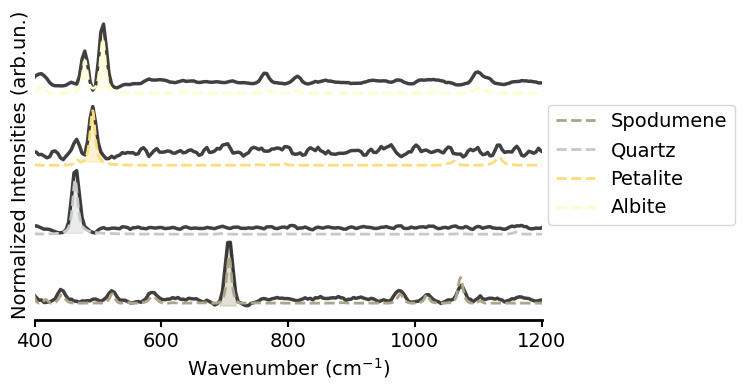

In [13]:
fig, ax = subplots(figsize = (8, 4))
from scipy.signal import savgol_filter

ax.spines[['right', 'top', 'left']].set_visible(False)
setp(ax.spines.values(), linewidth=2, color = 'k')
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params('x', colors='k')

height = [-3620, -2480, -1340, -150]


data = savgol_filter(np.mean(pro_data[32:34, 10:21, :], axis = (0, 1)), 5, 2)
ax.plot(wavelengths_raman, data, color = 'k', lw = 2.5, alpha = 0.75)
wv = find_index(wavelengths_raman, 509)
ax.fill_between(wavelengths_raman, data, np.min(data), where = (wavelengths_raman < wavelengths_raman[wv] + 15) & (wavelengths_raman > wavelengths_raman[wv] - 15), color = colors[0], alpha = 0.35)

data = savgol_filter(np.mean(pro_data[140:142, 29:31, :]*4/1.5 - 1200, axis = (0, 1)), 5, 2)
ax.plot(wavelengths_raman, data, color = 'k', lw = 2.5, alpha = 0.75)
wv = find_index(wavelengths_raman, 490)
ax.fill_between(wavelengths_raman, data, np.min(data), where = (wavelengths_raman < wavelengths_raman[wv] + 16) & (wavelengths_raman > wavelengths_raman[wv] - 15), color = colors[2], alpha = 0.35)

data = savgol_filter(np.mean(pro_data[151:153, 82:84, :]/1.5 - 1200*2, axis = (0, 1)), 5, 2)
ax.plot(wavelengths_raman, data, color = 'k', lw = 2.5, alpha = 0.75)
wv = find_index(wavelengths_raman, 464)
ax.fill_between(wavelengths_raman, data, np.min(data), where = (wavelengths_raman < wavelengths_raman[wv] + 16) & (wavelengths_raman > wavelengths_raman[wv] - 15), color = colors[3], alpha = 0.35)

data = savgol_filter(np.mean(pro_data[102:104, 52:54, :]*2/1.5 - 1200*3, axis = (0, 1)), 5, 2)
ax.plot(wavelengths_raman, data, color = 'k', lw = 2.5, alpha = 0.75)
wv = find_index(wavelengths_raman, 705)
ax.fill_between(wavelengths_raman, data, np.min(data), where = (wavelengths_raman < wavelengths_raman[wv] + 16) & (wavelengths_raman > wavelengths_raman[wv] - 15), color = colors[4], alpha = 0.35)
# ax.plot(wavelengths_raman, savgol_filter(np.sum(pro_data[32:34, 10:21, :] - 6000, axis = (0, 1)), 5, 3), color = colors[4], label = 'Spodumene', lw = 3)

mineral_list = ['Spodumene', 'Quartz', 'Petalite', 'Albite', 'Ref']
colors_ref = ['xkcd:stone', 'xkcd:silver',  'xkcd:wheat' , 'xkcd:ecru','xkcd:green']
for i,mineral in enumerate(mineral_list[:4]):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        ax.plot(wl, height[i] + 900 * spec/np.max(spec), color = colors_ref[i], lw = 2, ls = '--', label = mineral_list[i])
    except:
        print(mineral + ' not found')

ax.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize = 14)
# ax.set_yticks([])
ax.set_xlim(400, 1200)
ax.set_xticks([400, 600, 800, 1000, 1200])
ax.set_xticklabels([400, 600, 800, 1000, 1200], fontsize = 14)
ax.set_ylabel('Normalized Intensities (arb.un.)', fontsize = 14)

ax.tick_params(
    bottom=True, top=False,
    left=False, right=False, length = 5, width = 1.5)
ax.tick_params(
    labelbottom=True, labeltop=False,
    labelleft=False, labelright=False)

hls = []
for color, cluster in zip(colors_ref, mineral_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

# ax.set_title('Unsupervised Classification Results')
ax.legend(loc = 'center right',  bbox_to_anchor = (1.4, 0.5), ncol = 1, fontsize = 14)

ax.grid(False)
fig.tight_layout()
# savefig('raman_references2.jpg', dpi = 500)


# 2. Import LIBS Data

In [112]:
file = r"D:/Data/Data_LIBS/Rock_PE/High_res_map"
spectrum, wavelengths, positions, unique_x, unique_y = read_data_map(file)

(100, 220, 16384)


In [113]:
wavelengths = wavelengths.flatten()

## 2.1 Visualization

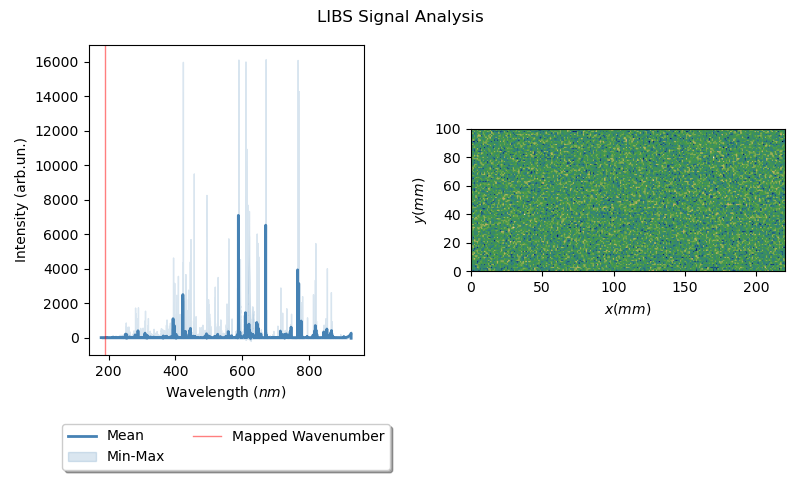

In [23]:
mean_signal = np.mean(spectrum, axis=(0,1))
min_signal = np.min(spectrum, axis=(0,1))
max_signal = np.max(spectrum, axis=(0,1))

nx, ny = spectrum.shape[1], spectrum.shape[0]

%matplotlib widget

fig, ax = subplots(1, 2, figsize = [8,5],gridspec_kw={'width_ratios':[0.7,0.8]})
fig.suptitle('LIBS Signal Analysis')
ax[0].plot(wavelengths, mean_signal, lw = 2,ls='-',color='steelblue',label='Mean')
ax[0].fill_between(wavelengths, min_signal,max_signal,color='steelblue',alpha=0.2,label='Min-Max')
wn=300
line = ax[0].axvline(wavelengths[wn],lw='1',alpha=0.5,color='red',label='Mapped Wavenumber')
ax[0].set_xlabel(r'Wavelength $(nm)$')
ax[0].set_ylabel(r'Intensity (arb.un.)')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2, fancybox=True, shadow=True)


ax[1].imshow(spectrum[:,:,wn],cmap=cm.gist_earth, extent=[0,nx,0,ny])
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(spectrum[:,:,wn],cmap=cm.inferno,
                     extent=[0,nx,0,ny],
                     interpolation='gaussian')
    line.set_xdata(wavelengths[wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_wavelength_index(ix, wavelengths)
    if event.inaxes == ax[0] or event.inaxes == ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)

fig.tight_layout()

### 2.1.1 Visualize Relevant LIBS maps

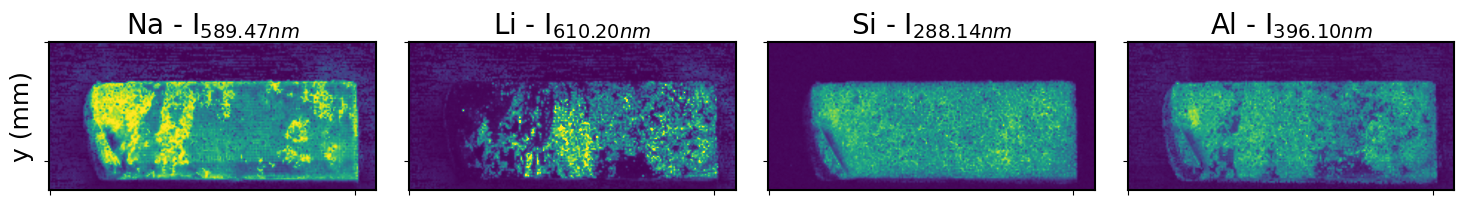

In [16]:
fig, ax = subplots(1, 4, figsize = (15, 15))


eles = ['Na', 'Li', 'Si', 'Al']
lines = [589.47, 330.22, 588.89, 610.2, 460.28, 670.78, 288.14, 251.54, 212.36, 396.1, 309.24, 237.24]
vmax = [16000, 6500, 1500, 1200]

for i in range(len(eles)):
    axs = ax[i]
    setp(axs.spines.values(), linewidth = 1.5, color = 'k')
    axs.imshow(spectrum[::-1, ::-1, find_wavelength_index(lines[i*3], wavelengths)], cmap = 'viridis', interpolation = 'gaussian', vmin = 0, vmax = vmax[i])
    axs.set_title(f'{eles[i]}' + r' - I$_{%.2fnm}$' %(lines[i*3]), fontsize = 20)
    axs.set_yticks([0, 80])
    axs.set_yticklabels([], fontsize = 18)
    axs.set_xticks([0, 205])
    axs.set_xticklabels([], fontsize = 18)
    if i == 0:
        axs.set_ylabel('y (mm)', fontsize = 18)
    # axs.set_xlabel('x (mm)', fontsize = 18)

fig.tight_layout(pad = 2)
# savefig(r'Images/libs_lines.jpg', dpi = 300)

## 2.2 Plot the Spectra

(<Figure size 700x500 with 1 Axes>, None)

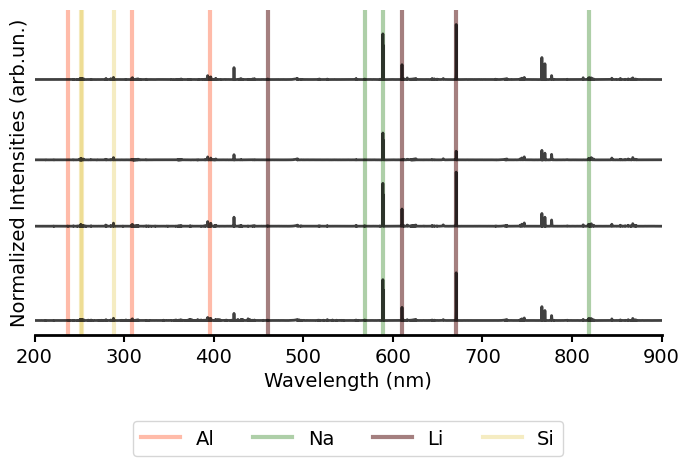

In [17]:
fig, ax = subplots(figsize = (7, 5))
from scipy.signal import savgol_filter

ax.spines[['right', 'top', 'left']].set_visible(False)
setp(ax.spines.values(), linewidth = 2, color = 'k')
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params('x', colors='k')

mineral_list = ['Spodumene', 'Quartz', 'Petalite', 'Albite', 'Ref']
colors_ref = ['xkcd:stone', 'xkcd:silver',  'xkcd:wheat' , 'xkcd:ecru','xkcd:green']

radius = 1

wls = [460.29, 610.36, 670.76, 237.22, 309.21, 396.09, 251.59, 252.81, 288.16, 568.766, 588.95, 819.40]
al = [237.22, 309.21, 396.09]
li = [460.29, 610.36, 670.76]
na = [568.766, 588.95, 819.40]
si = [251.59, 252.81, 288.16]

# ele = Li Al Si Na

data = savgol_filter(np.mean(spectrum[10-radius:10+radius, 15-radius:15+radius, :], axis = (0, 1)), 5, 2)/8
for i, wv in enumerate(al):
    wl = find_wavelength_index(wv, wavelengths)
    if i == 0:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:melon', alpha = 0.5, lw = 3, 
                   label = 'Al')
    else:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:melon', alpha = 0.5, lw = 3)
for i, wv in enumerate(na):
    wl = find_wavelength_index(wv, wavelengths)
    if i == 0:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:muted green', alpha = 0.5, 
                   lw = 3, label = 'Na')
    else:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:muted green', alpha = 0.5, 
                   lw = 3)
for i, wv in enumerate(li):
    wl = find_wavelength_index(wv, wavelengths)
    if i == 0:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:dried blood', alpha = 0.5, lw = 3, 
                   label = 'Li')
    else:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:dried blood', alpha = 0.5, 
                   lw = 3)
for i, wv in enumerate(si):
    wl = find_wavelength_index(wv, wavelengths)
    if i == 0:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:gold', alpha = 0.25, lw = 3, 
                   label = 'Si')
    else:
        ax.axvline(wv, ymin = np.min(data), ymax = np.max(data), 
                   color = 'xkcd:gold', alpha = 0.25, lw = 3)
ax.plot(wavelengths, data, color = 'k', lw = 2, alpha = 0.75)

data = savgol_filter(np.mean(spectrum[12-radius:12+radius, 70-radius:70+radius, :], axis = (0, 1)), 5, 2)/8 - 2300
ax.plot(wavelengths, data, color = 'k', lw = 2, alpha = 0.75)

data = savgol_filter(np.mean(spectrum[34-radius:34+radius, 70-radius:70+radius, :], axis = (0, 1)), 5, 2)/8 - 2100*2
ax.plot(wavelengths, data, color = 'k', lw = 2, alpha = 0.75)

data = savgol_filter(np.mean(spectrum[25-radius:25+radius, 51-radius:51+radius, :], axis = (0, 1)), 5, 2)/8 - 2300*3
ax.plot(wavelengths, data, color = 'k', lw = 2, alpha = 0.75)

# wv = find_index(wavelengths_raman, 509)
# ax.fill_between(wavelengths_raman, data, np.min(data), where = (wavelengths_raman < wavelengths_raman[wv] + 15) & (wavelengths_raman > wavelengths_raman[wv] - 15), color = colors[0], alpha = 0.35)

ax.set_xlabel(r'Wavelength (nm)', fontsize = 14)
# ax.set_yticks([])
ax.set_xlim(200, 900)
ax.set_xticks([200, 300, 400, 500, 600, 700, 800, 900])
ax.set_xticklabels([200, 300, 400, 500, 600, 700, 800, 900], fontsize = 14)
ax.set_ylabel('Normalized Intensities (arb.un.)', fontsize = 14)

ax.tick_params(
    bottom=True, top=False,
    left=False, right=False, length = 5, width = 1.5)
ax.tick_params(
    labelbottom=True, labeltop=False,
    labelleft=False, labelright=False)

hls = []
for color, cluster in zip(colors_ref, mineral_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

# ax.set_title('Unsupervised Classification Results')
ax.legend(loc = 'lower center',  bbox_to_anchor = (0.5, -0.4), ncol = 4, fontsize = 14)

ax.grid(False)
fig,tight_layout()
# savefig('libs_references_new_color.jpg', dpi = 500)

# 3. Optical Image

In [18]:
from skimage import io
rock_image = io.imread(r'C:/Users/tomas/Downloads/PetalideEspodumena_ADG_2_40_8.jpg')
rock_image = rock_image[210:1100, 100:2000]

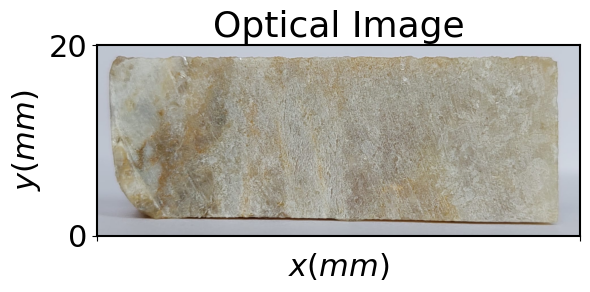

In [19]:
fig, ax = subplots(1, 1, figsize = (6, 4))


axs = ax
setp(axs.spines.values(), linewidth = 1.5, color = 'k')
wn = 670.76
axs.imshow(rock_image[50:720, 100:1800])
# im = axs.imshow(spectrum[:, :, find_wavelength_index(wn, wavelengths)], interpolation = 'gaussian', alpha = 0.55*np.abs(spectrum[:, :, find_wavelength_index(wn, wavelengths)]/np.max(spectrum[:, :, find_wavelength_index(wn, wavelengths)])))
axs.set_title(r'Optical Image', size = 26)
axs.grid(False)
axs.set_xlabel(r'$x (mm)$',fontsize = 22)
axs.set_ylabel(r'$y (mm)$',fontsize = 22)
axs.set_xticks([0, 1700])
axs.set_xticklabels([], fontsize=22)
axs.set_yticks([0, 670])
axs.set_yticklabels([20, 0], fontsize=22)
# cbar = colorbar(im, fraction = 0.0215, pad = 0.04)
# cbar.set_ticks([0, 16000])
# cbar.set_ticklabels([r'$0$', r'$16000$'], fontsize = 14)
# cbar.solids.set(alpha=0.7)

fig.tight_layout()
# fig.savefig(r'Images/rock_optical.jpg', dpi = 300, bbox_inches = 'tight')

# 4. Dataset Alignment

In [114]:
spectrum = spectrum[0:80, 0:205]

In [115]:
im1 = np.array(spectrum[:, :, find_wavelength_index(588.75, wavelengths)])
mmap = np.array(pro_data[:, :, find_index(wavelengths_raman, 508.1)])

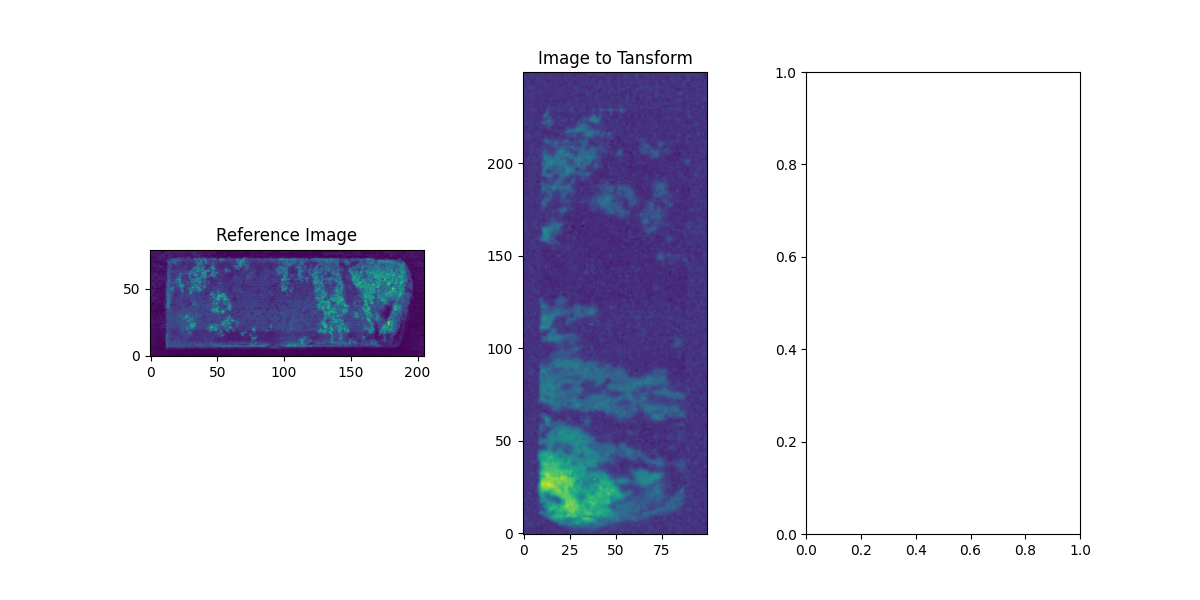

In [117]:
%matplotlib widget

aligner = align(im1, mmap)

## 4.1 Verify Alignment

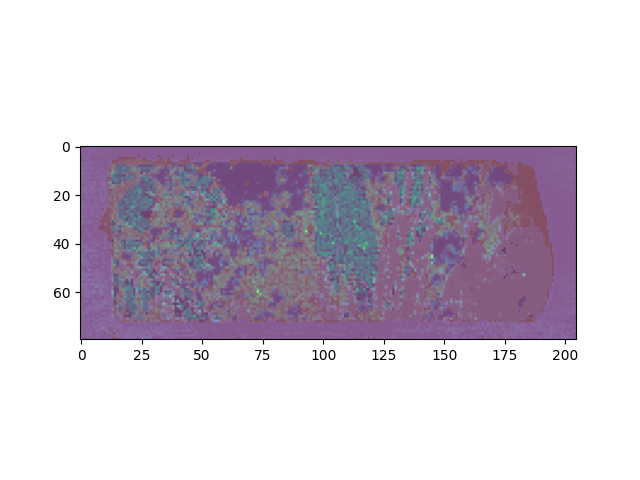

In [118]:
aligner.transform(predictions.reshape(norm_data.shape[0], norm_data.shape[1]), val = 1)
aligned_labels = aligner.new_data

subplots()
imshow(aligned_labels, cmap = cmp1)
imshow(spectrum[:, :, find_wavelength_index(610.22, wavelengths)], alpha = 0.65)

# 5. Multimodal Spectral Knowledge Distillation

## 5.1 Ridge Regression

### 5.1.1 Normalize each spectrum to volume | Apply Gaussian Filter to each map

In [130]:
spectrum_vol = np.array(spectrum).reshape(spectrum.shape[0]*spectrum.shape[1], -1)
spectrum_vol = np.array([spectrum_vol[i, :]/np.sum(spectrum_vol[i, :]) for i in range(spectrum_vol.shape[0])]).reshape(spectrum.shape)
mskd_data = np.array([filters.gaussian(spectrum_vol[:, :, wn], sigma = 0.5) for wn in tqdm(range(spectrum_vol.shape[-1]))])
    
mskd_data = np.transpose(np.array(mskd_data), axes = (1, 2, 0))
mskd_data = mskd_data.reshape([mskd_data.shape[0]*mskd_data.shape[1], -1])

100%|██████████| 16384/16384 [00:26<00:00, 610.53it/s]


In [131]:
mskd_labels = aligned_labels.reshape(aligned_labels.shape[0]*aligned_labels.shape[1])

# mskd_data = sklearn.preprocessing.MaxAbsScaler().fit_transform(mskd_data)
mskd_data = np.array([mskd_data[i, :]/np.sum(mskd_data[i, :]) for i in range(mskd_data.shape[0])])
mskd_data_train, mskd_data_test, mskd_train, mskd_test = sklearn.model_selection.train_test_split(mskd_data, mskd_labels, test_size = 0.10, random_state = 80)

plsr = sklearn.linear_model.RidgeClassifier(alpha = 5e-4)
plsr.fit(mskd_data_train, mskd_train)

pls_da = plsr.predict(mskd_data)
# pls_pred = pls_da.argmax(axis = 1)

## 5.2 4-Fold for $\alpha$ parameter tuning

In [33]:
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")

n_alphas = 20
alphas = np.logspace(-7, -1, n_alphas)
accu_train = []
accu_test = []
std_train = []
std_test = []

kFold = KFold(n_splits = 4, shuffle = False)
for a in tqdm(alphas):
    ridge = sklearn.linear_model.RidgeClassifier(alpha = a, fit_intercept = False)
    accu_4fold_train = []
    accu_4fold_test = []
    for train_index, test_index in kFold.split(mskd_data):
        X_train, X_test, y_train, y_test = mskd_data[train_index], mskd_data[test_index], mskd_labels[train_index], mskd_labels[test_index]
        ridge.fit(X_train, y_train)

        lbls_train = ridge.predict(X_train)
        lbls_test = ridge.predict(X_test)

        accuracy_train = len(np.where(lbls_train == y_train)[0])/len(y_train) * 100
        accuracy_test = len(np.where(lbls_test == y_test)[0])/len(y_test) * 100

        accu_4fold_train.append(accuracy_train)
        accu_4fold_test.append(accuracy_test)

    accu_train.append(np.mean(accu_4fold_train))
    accu_test.append(np.mean(accu_4fold_test))
    std_test.append(np.std(accu_4fold_test))
    std_train.append(np.std(accu_4fold_train))

100%|██████████| 20/20 [48:25<00:00, 145.26s/it]


In [34]:
accu_test = np.array(accu_test)
accu_train = np.array(accu_train)
std_train = np.array(std_train)
std_test = np.array(std_test)

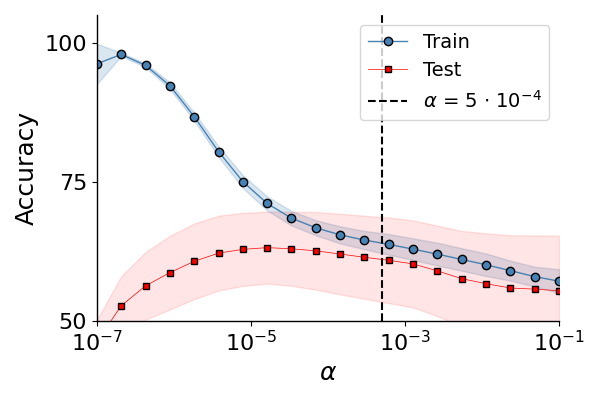

In [35]:
fig, ax = subplots(figsize = (6, 4))

axs = ax
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.plot(alphas, accu_train, color = 'steelblue', lw =1,marker='o',markeredgecolor='k',markeredgewidth=1, label = 'Train')
axs.fill_between(alphas, accu_train - std_train, accu_train + std_train, color = 'steelblue', alpha = 0.2)
axs.plot(alphas, accu_test, color = 'r', lw = .5,marker='s',markeredgecolor='k',markeredgewidth=1,ms=4, label = 'Test')
axs.fill_between(alphas, accu_test - std_test, accu_test + std_test, color = 'r', alpha = 0.1)
axs.axvline(5e-4, ls = '--', color = 'k', label = r'$\alpha$ = 5 $\cdot$ 10$^{-4}$')
# axs.axvspan(xmin = 1e-4, xmax = 0.0025, color = 'k', alpha = 0.1)

axs.legend(fontsize = 14)


axs.set_xscale('log')
axs.set_xlabel(r'$\alpha$', fontsize = 18)
axs.set_ylabel('Accuracy', fontsize = 18)
axs.set_ylim(50, 105)
axs.set_xlim(1e-7, 1e-1)
axs.tick_params(axis = 'x', labelsize = 16)
axs.set_yticks([50, 75, 100])
axs.set_yticklabels([50, 75, 100], fontsize = 16)

axs.grid(False)
fig.tight_layout()
axs.spines[['top', 'right']].set_visible(False)

# savefig('Images/parameter_tuning.jpg', dpi = 300)

# 6. Standalone LIBS Clustering

## 6.1 Normalize each spectrum to its sum | Normalize each map to [0-1] range

In [120]:
spec_shape = spectrum.shape

In [121]:
features = []
radius = 2

spectrum = spectrum.reshape(spectrum.shape[0]*spectrum.shape[1], -1)

spectrum_mabs = np.array([spectrum[i, :]/np.sum(spectrum[i, :])
                         for i in tqdm(range(spectrum.shape[0]))
                         ])

spectrum = spectrum.reshape(spec_shape)
spectrum_mabs = spectrum_mabs.reshape(spec_shape)

wls = [460.29, 610.36, 670.76, 237.22, 309.21, 396.09, 251.59, 252.81, 288.16, 568.766, 588.95, 819.40, 422.69, 430.2]
# ele = Li Al Si Na

for i in tqdm(range(len(wls))):
    wn = find_wavelength_index(wls[i], wavelengths)
    new_array = filters.gaussian(spectrum_mabs[:, :, wn-radius : wn+radius].mean(axis = -1), sigma = 0.5)
    features.append( ( new_array - np.min(new_array) ) / (np.max(new_array) - np.min(new_array)))
    
features = np.transpose(np.array(features), axes = (1, 2, 0))
features = features.reshape([features.shape[0]*features.shape[1],features.shape[2]])

100%|██████████| 14/14 [00:00<00:00, 112.69it/s]


## 6.2 Clustering

In [122]:
init_libs = clusters_init = [ [0,0,0,1,1,1,0,0,0,1,1,1,1,1], 
                              [0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                              [1,1,1,1,1,1,1,1,1,0,0,0,0,0], 
                              [0,0,0,0,0,0,1,1,1,0,0,0,0,0], 
                              [1,1,1,1,1,1,1,1,1,0,0,0,0,0] ]

clusterer = sklearn.cluster.KMeans(n_clusters = 5, random_state = 100, init = np.array(init_libs))
pred_l = clusterer.fit_predict(features)
pred_map = pred_l.reshape(spectrum_mabs.shape[0], spectrum_mabs.shape[1])

In [123]:
libs_data_train, libs_data_test = sklearn.model_selection.train_test_split(features, test_size = 0.10, random_state = 80)

# 7. Compare Results of all Workflows

## 7.1 Visual Analysis

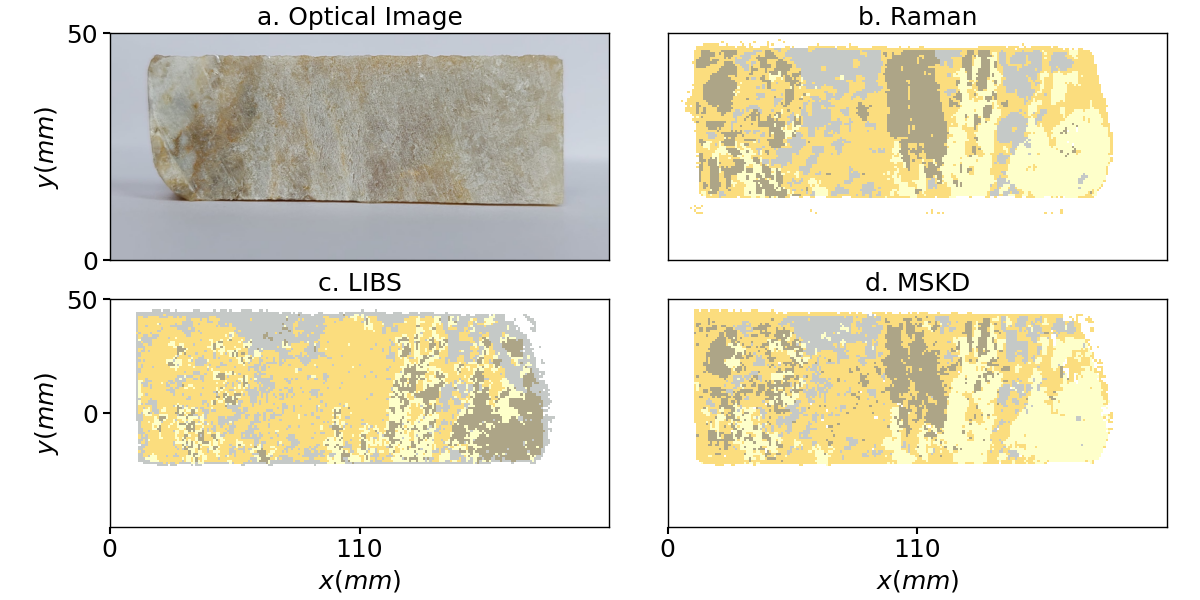

In [132]:
fig, ax = subplots(2, 2, figsize = (12, 6))

accuracy = len(np.where(pls_da == mskd_labels)[0])/len(mskd_labels) * 100
mineral = ['Albite', 'Background', 'Petalite', 'Quartz', 'Spodumene']
# colors = ['xkcd:buff', 'xkcd:white',  'xkcd:maize' , 'xkcd:silver','xkcd:mud']
colors = ['xkcd:ecru', 'xkcd:white',  'xkcd:wheat' , 'xkcd:silver','xkcd:stone']

cmp2 = ListedColormap(colors[:n_clusters])


hls = []
for color, cluster in zip(colors, mineral):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

# fig.suptitle(f'Accuracy is: {accuracy:.1f}%', fontsize = 20)
axs = ax[0, 0] 
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(rock_image, extent = (0, 110, 50, 0))
# im = axs.imshow(spectrum[:, :, find_wavelength_index(wn, wavelengths)], interpolation = 'gaussian', alpha = 0.55*np.abs(spectrum[:, :, find_wavelength_index(wn, wavelengths)]/np.max(spectrum[:, :, find_wavelength_index(wn, wavelengths)])))
axs.set_title('a. Optical Image', size = 18)
axs.grid(False)
# axs.set_xlabel(r'$x (mm)$',fontsize = 18)
axs.set_ylabel(r'$y (mm)$',fontsize = 18)
axs.set_xticks([])
# axs.set_xticklabels([0, 110], fontsize=18)
axs.set_yticks([0, 50])
axs.set_yticklabels([50, 0], fontsize=18)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1.5)

axs = ax[0, 1]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.set_title('b. Raman', fontsize = 18)
axs.imshow(mskd_labels.reshape(spectrum.shape[:2]), cmap = cmp2, interpolation = 'nearest')
# fig.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (0.5, -0.02), ncol = 5, fontsize = 16)
# axs.set_xlabel(r'$x(mm)$',fontsize = 18)
axs.grid(False)
# axs.set_ylabel(r'$y(mm)$',fontsize = 18)
axs.set_xticks([])
axs.set_yticks([])
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1.5)
axs.set_xlim(0, 220)
axs.set_ylim(100, 0)

axs = ax[1, 0]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(pred_map.reshape(spectrum.shape[:2]), cmap = cmp2, interpolation = 'nearest')
axs.set_title('c. LIBS', fontsize = 18)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize = 18)
axs.set_ylabel(r'$y(mm)$',fontsize = 18)
axs.set_xticks([0,110])
axs.set_xticklabels([0, 110], fontsize = 18)
axs.set_yticks([0, 50])
axs.set_yticklabels([50, 0], fontsize = 18)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1.5)
axs.set_xlim(0, 220)
axs.set_ylim(100, 0)
axs = ax[1, 1]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(pls_da.reshape(spectrum.shape[0], spectrum.shape[1]), cmap = cmp2, interpolation = 'nearest')
axs.set_title('d. MSKD', fontsize = 18)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize = 18)
# axs.set_ylabel(r'$y(mm)$',fontsize = 18)
axs.set_xticks([0,110])
axs.set_xticklabels([0, 110], fontsize = 18)
axs.set_yticks([0, 50])
axs.set_yticklabels([0, 50], fontsize = 18)
axs.set_xlim(0, 220)
axs.set_ylim(100, 0)


axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1.5)

axs = ax[1, 1]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(pls_da.reshape(spectrum.shape[0], spectrum.shape[1]), cmap = cmp2, interpolation = 'nearest')
axs.set_title('d. MSKD', fontsize = 18)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize = 18)
# axs.set_ylabel(r'$y(mm)$',fontsize = 18)
axs.set_xticks([0,110])
axs.set_xticklabels([0, 110], fontsize = 18)
axs.set_yticks([])
axs.set_xlim(0, 220)
axs.set_ylim(100, 0)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1.5)

fig.tight_layout()
# savefig('C:/Users/tomas/Desktop/results_clustering_lr1.jpg', dpi = 300, bbox_inches = 'tight')

In [147]:
print(f'Standalone LIBS Accuracy: {(sum(pred_map.reshape(mskd_labels.shape) == mskd_labels)/len(mskd_labels)*100):.2f}%')
print(f'MSKD Accuracy: {(sum(pls_da == mskd_labels)/len(mskd_labels)*100):.2f}%')

Standalone LIBS Accuracy: 57.01%
MSKD Accuracy: 78.01%


## 7.2 Confusion Matrix

In [136]:
from sklearn import metrics

libs_confusion = metrics.confusion_matrix(mskd_test, clusterer.predict(libs_data_test))
mskd_confusion = metrics.confusion_matrix(mskd_test, plsr.predict(mskd_data_test))

In [137]:
libs_confusion = np.array(libs_confusion, dtype = float)
mskd_confusion = np.array(mskd_confusion, dtype = float)

for i in range(libs_confusion.shape[0]):
    libs_confusion[i] /= np.sum(libs_confusion[i])
    mskd_confusion[i] /= np.sum(mskd_confusion[i])

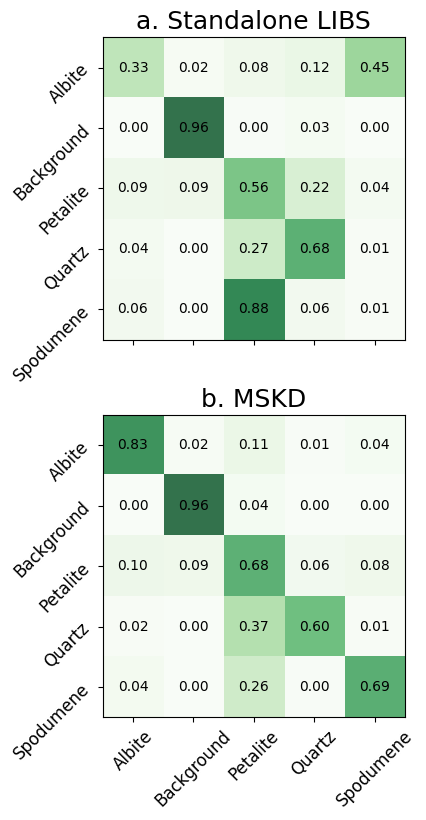

In [167]:
%matplotlib inline
fig, axs = subplots(2, 1, figsize = (4, 8))
# ax.imshow(libs_confusion, cmap = 'Greens')

ax = axs[0]
ax.set_title('a. Standalone LIBS', fontsize = 18)
ax.imshow(libs_confusion, cmap = 'Greens', alpha = 0.8, vmax = 1, vmin = 0)
for i in range(libs_confusion.shape[0]):
    for j in range(libs_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticklabels([], rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral, fontsize = 12, rotation = 45)

# ax.set_xlabel('Predictions', fontsize = 16)
# ax.set_ylabel('Ground Truth', fontsize = 16)

ax = axs[1]
ax.set_title('b. MSKD', fontsize = 18)
ax.imshow(mskd_confusion, cmap = 'Greens', alpha = 0.8, vmax = 1, vmin = 0)
for i in range(mskd_confusion.shape[0]):
    for j in range(mskd_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{mskd_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticklabels(mineral, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral, fontsize = 12, rotation = 45)

# ax.set_xlabel('Predictions', fontsize = 16)
# fig.supxlabel('            Predictions', fontsize = 16)
# fig.supylabel('      Ground Truth', fontsize = 16)

# ax.set_ylabel('Ground Truth', fontsize = 16)

fig.tight_layout(pad = 0)

fig.savefig("Images/confusion_matrix.jpg", dpi = 300, bbox_inches = 'tight')

## 7.3 Interpret Ridge Classifier by analysing Regression Coeficients

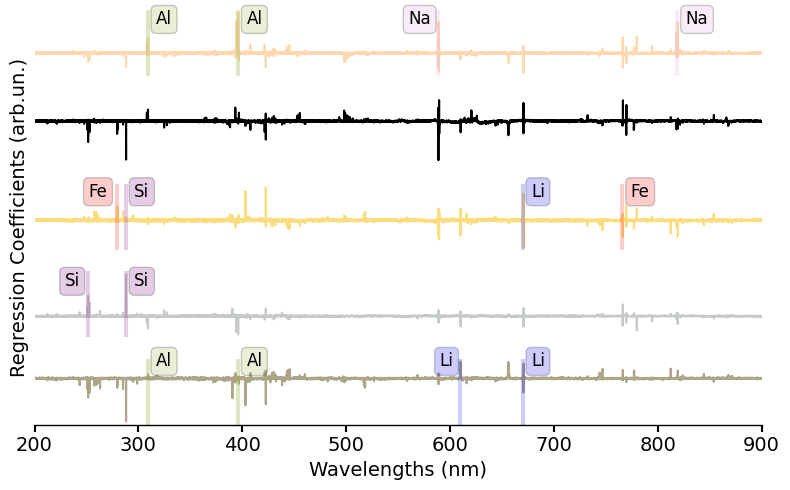

In [145]:
fig, ax = subplots(5, 1, figsize = (8, 5))
inds = [0, 1, 2, 3, 4]
y_min1 = [-0.001, 0.000]
y_max1 = [0.001, 0.002] 

# colors1 = ['xkcd:dark coral','xkcd:beige','xkcd:sandy','xkcd:almost black','xkcd:topaz']
colors1 = ['xkcd:light peach', 'xkcd:black',  'xkcd:wheat' , 'xkcd:silver','xkcd:stone']
props_na = dict(boxstyle = 'round', facecolor='plum', alpha=0.2)
props_li = dict(boxstyle = 'round', facecolor='blue', alpha=0.2)
props_si = dict(boxstyle = 'round', facecolor='purple', alpha=0.2)
props_fe = dict(boxstyle = 'round', facecolor='red', alpha=0.2)
props_al = dict(boxstyle = 'round', facecolor='xkcd:avocado', alpha=0.2)

mineral_list = ['Albite', 'Background', 'Petalite', 'Quartz', 'Spodumene']


for i in range(0, 5):
    axs = ax[i]
    axs.plot(wavelengths, plsr.coef_[inds[i], :], color = colors1[inds[i]])
    setp(axs.spines.values(), linewidth=1, color = 'k')

    # axs.plot(wavelengths, plsr.coef_[:, inds[i]], color = colors1[inds[i]])
    # axs.set_title(mineral_list[inds[i]], fontsize = 16)
    if i == 0:
        axs.text(588.86 -29, np.max(plsr.coef_[inds[i], :])/1.4, f'Na', fontsize = 12, bbox = props_na)
        axs.axvline(588.86, lw = '3', alpha = 0.2, color = 'plum')

        axs.text(819 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Na', fontsize = 12, bbox = props_na)
        axs.axvline(819, lw = '3', alpha = 0.2, color = 'plum')

        axs.text(309 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Al', fontsize = 12, bbox = props_al)
        axs.axvline(309, lw = '3', alpha = 0.3, color = 'xkcd:avocado')

        axs.text(396 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Al', fontsize = 12, bbox = props_al)
        axs.axvline(396, lw = '3', alpha = 0.3, color = 'xkcd:avocado')
        axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

        axs.tick_params(
            bottom=False, top=False,
            left=False, right=False, length = 5, width = 1.5)
        axs.tick_params(
            labelbottom=False, labeltop=False,
            labelleft=False, labelright=False)

    if i == 1:
        axs.tick_params(
            bottom=False, top=False,
            left=False, right=False, length = 5, width = 1.5)
        axs.tick_params(
            labelbottom=False, labeltop=False,
            labelleft=False, labelright=False)
        axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

    if i == 2:
        axs.text(766 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Fe', fontsize = 12, bbox = props_fe)
        axs.axvline(766, lw = '3', alpha = 0.2, color = 'red')

        axs.text(670 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Li', fontsize = 12, bbox = props_li)
        axs.axvline(670, lw = '3', alpha = 0.2, color = 'blue')

        axs.text(288 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Si', fontsize = 12, bbox = props_si)
        axs.axvline(288, lw = '3', alpha = 0.2, color = 'purple')

        axs.text(279 -27, np.max(plsr.coef_[inds[i], :])/1.4, f'Fe', fontsize = 12, bbox = props_fe)
        axs.axvline(279, lw = '3', alpha = 0.2, color = 'red')

        axs.tick_params(
            bottom=False, top=False,
            left=False, right=False, length = 5, width = 1.5)
        axs.tick_params(
            labelbottom=False, labeltop=False,
            labelleft=False, labelright=False)
        axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)


        axs.set_ylabel(r'Regression Coefficients (arb.un.)',fontsize = 14)
    if i == 3:
        axs.text(288 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Si', fontsize = 12, bbox = props_si)
        axs.axvline(288, lw = '3', alpha = 0.2, color = 'purple')

        axs.text(251 -22, np.max(plsr.coef_[inds[i], :])/1.4, f'Si', fontsize = 12, bbox = props_si)
        axs.axvline(251, lw = '3', alpha = 0.2, color = 'purple')

        axs.tick_params(
            bottom=False, top=False,
            left=False, right=False, length = 5, width = 1.5)
        axs.tick_params(
            labelbottom=False, labeltop=False,
            labelleft=False, labelright=False)
        axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
 
    if i == 4:
        axs.spines[['right', 'top', 'left']].set_visible(False)
        axs.text(670 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Li', fontsize = 12, bbox = props_li)
        axs.axvline(670, lw = '3', alpha = 0.2, color = 'blue')

        axs.text(610 -20, np.max(plsr.coef_[inds[i], :])/1.4, f'Li', fontsize = 12, bbox = props_li)
        axs.axvline(610, lw = '3', alpha = 0.2, color = 'blue')

        axs.text(309 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Al', fontsize = 12, bbox = props_al)
        axs.axvline(309, lw = '3', alpha = 0.3, color = 'xkcd:avocado')

        axs.text(396 +8, np.max(plsr.coef_[inds[i], :])/1.4, f'Al', fontsize = 12, bbox = props_al)
        axs.axvline(396, lw = '3', alpha = 0.3, color = 'xkcd:avocado')

        axs.tick_params(
            bottom=True, top=False,
            left=False, right=False, length = 5, width = 1.5)
        axs.tick_params(
            labelbottom=True, labeltop=False,
            labelleft=False, labelright=False)

        axs.set_xlabel(r'Wavelengths (nm)',fontsize = 14)

    
    axs.set_yticks([np.min(plsr.coef_[inds[i], :]), np.max(plsr.coef_[inds[i], :])])
    axs.set_yticklabels([int(np.min(plsr.coef_[inds[i], :])), int(np.max(plsr.coef_[inds[i], :]))],fontsize=14)
    axs.set_xticks([200,300,400,500,600,700,800,900])
    axs.set_xticklabels([200,300,400,500,600,700,800,900],fontsize=14)
    # # axs.set_ylim(0.3, 0.6)
    axs.set_xlim(200, 900)
    axs.grid(False)

fig.tight_layout()
# savefig('interpretability_ridge.jpg', dpi = 300)

# 8. Images for Article

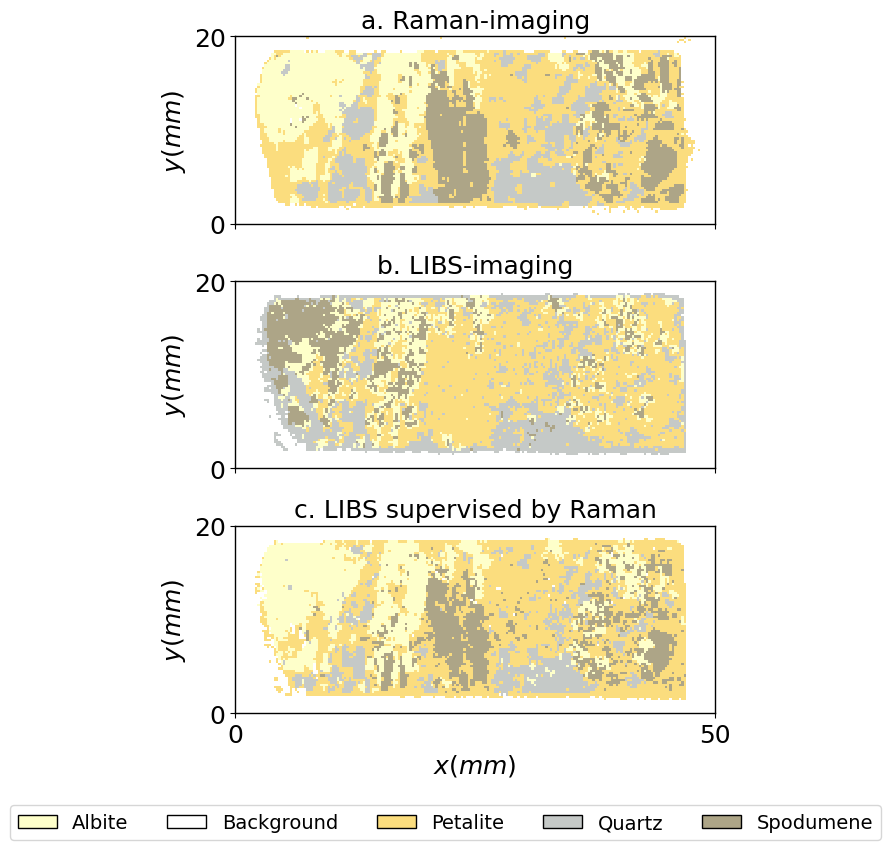

In [182]:
fig, ax = subplots(3, 1, figsize = (6, 8))

axs = ax[0]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.set_title('a. Raman-imaging', fontsize = 18)
axs.imshow(mskd_labels.reshape(spectrum.shape[:2])[::-1, ::-1], cmap = cmp2, interpolation = 'nearest')
# fig.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (0.5, -0.02), ncol = 5, fontsize = 16)
# axs.set_xlabel(r'$x(mm)$',fontsize = 18)
axs.grid(False)
axs.set_ylabel(r'$y (mm)$',fontsize = 18)
axs.set_xticks([0,205])
axs.set_xticklabels([], fontsize = 18)
axs.set_yticks([0, 80])
axs.set_yticklabels([20, 0], fontsize = 18)
axs.set_xlim(0, 205)
axs.set_ylim(80, 0)

axs = ax[1]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(pred_map.reshape(spectrum.shape[:2])[::-1, ::-1], cmap = cmp2, interpolation = 'nearest')
axs.set_title('b. LIBS-imaging', fontsize = 18)
axs.grid(False)
axs.set_ylabel(r'$y (mm)$',fontsize = 18)
axs.set_xticks([0,205])
axs.set_xticklabels([], fontsize = 18)
axs.set_yticks([0, 80])
axs.set_yticklabels([20, 0], fontsize = 18)
axs.set_xlim(0, 205)
axs.set_ylim(80, 0)

axs = ax[2]
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(pls_da.reshape(spectrum.shape[:2])[::-1, ::-1], cmap = cmp2, interpolation = 'nearest')
axs.set_title('c. LIBS supervised by Raman', fontsize = 18)
axs.grid(False)
axs.set_xlabel(r'$x (mm)$',fontsize = 18)
axs.set_ylabel(r'$y (mm)$',fontsize = 18)
axs.set_xticks([0,205])
axs.set_xticklabels([0, 50], fontsize = 18)
axs.set_yticks([0, 80])
axs.set_yticklabels([20, 0], fontsize = 18)
axs.set_xlim(0, 205)
axs.set_ylim(80, 0)

fig.legend(handles = hls, loc = 'lower center', 
            bbox_to_anchor = (0.5, -0.07), ncol = 5, 
            fontsize = 14)

fig.tight_layout()
# savefig("Images/results_libs_raman_all.jpg", dpi = 300)

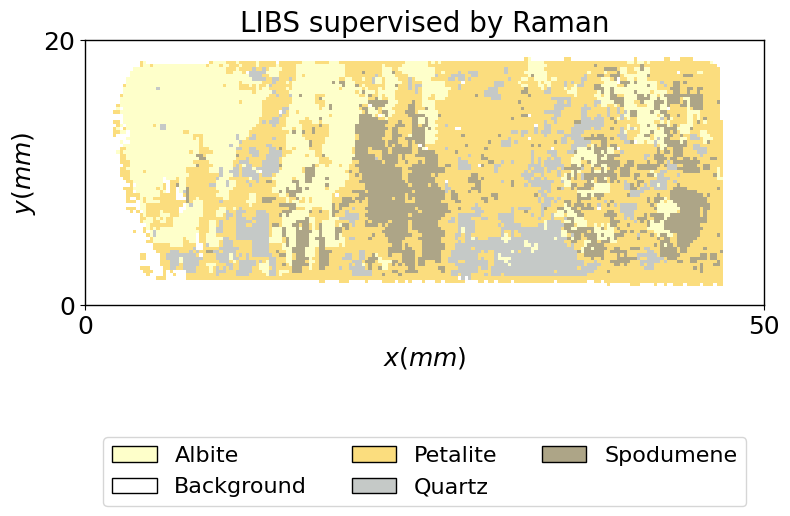

In [144]:
fig, ax = subplots(figsize = (8, 6))

axs = ax
setp(axs.spines.values(), linewidth=1, color = 'k')
axs.imshow(pls_da.reshape(spectrum.shape[0], spectrum.shape[1])[::-1, ::-1], cmap = cmp1, interpolation = 'nearest')
axs.set_title('LIBS supervised by Raman', fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize = 18)
axs.set_ylabel(r'$y(mm)$',fontsize = 18)
axs.set_xticks([0,205])
axs.set_xticklabels([0, 50], fontsize = 18)
axs.set_yticks([0, 80])
axs.set_yticklabels([20, 0], fontsize = 18)
axs.set_xlim(0, 205)
axs.set_ylim(80, 0)

axs.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (0.5, -0.8), ncol = 3, fontsize = 16)
fig.tight_layout()
# savefig('Images/results_mskd_final.jpg', dpi = 300)